# <ins>Song Lyrics Through the Years</ins>

# Data Cleaning

- In this notebook, I look at the data I scraped from [Top 40 Weekly](https://top40weekly.com/) and [Genius](https://genius.com) in the previous [notebook](01_webscraping.ipynb).
- I check for and rectify duplicate (or near-duplicate) entries, NaN values, and songs that need to be rescraped.


## Table of contents

1. [Load packages and data](#Load-packages-and-data)
2. [Check for duplicates](#Check-for-duplicates)

    - [Drop duplicates](#Drop-duplicates)
    - [Scrape extra pages](#Scrape-extra-pages)
    - [Add titles](#Add-titles)
  
  
3. [Check for NaN values](#Check-for-NaN-values)
4. [Check for other bad scrapes](#Check-for-other-bad-scrapes)

    - [Finishing touches](#Finishing-touches)
    - [Save DataFrame](#💾-Save-DataFrame)
    
    
5. [Drop certain genres](#Drop-certain-genres)

    - [Save/Load trimmed DataFrame](#💾-Save/Load-trimmed-DataFrame)
    
    
6. [Next notebook: NLP, Feature Engineering, and EDA](#Next-notebook:-NLP,-Feature-Engineering,-and-EDA)

    
## Load packages and data

[[go back to the top](#Predicting-Poetic-Movements)]

In [1]:
# custom functions for webscraping
from functions.webscraping import *

# standard dataframe packages
import pandas as pd
import numpy as np

# graphing packages
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('ticks')

# timekeeping/progress packages
import time
from tqdm import tqdm

# saving/loading packages
import gzip
import pickle
import json

# reload functions/libraries when edited
%load_ext autoreload
%autoreload 2

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# increase column width of dataframe
pd.set_option('max_colwidth', 150)

In [2]:
# load data
with gzip.open('data/lyrics_df_updated.pkl', 'rb') as hello:
    df = pickle.load(hello)

In [3]:
df.head()

,year,title,artist,lyrics
0,1960,THE VILLAGE OF ST. BERNADETTE,Andy Williams,"I've traveled far, the land and the sea\nBeautiful places I happened to be\nOne little town I'll never forget\nIs Lourdes, the village of St. Bern..."
1,1960,IN MY LITTLE CORNER OF THE WORLD,Anita Bryant,"Oh, come along with me\nTo my little corner of the world\nAnd dream a little dream\nIn my little corner of the world\n\nTonight, my love\nWe'll sh..."
2,1960,PAPER ROSES,Anita Bryant,I realize the way your eyes deceived me\nWith tender looks that I mistook for love\nSo take away the flowers that you gave me\nAnd send the kind t...
3,1960,O DIO MIO,Annette,"E un giorno lui mi disse: ""Nei tuoi occhi vedo fame\nNon vedo rabbia, figlio, no\nMa voglia di lottare.""\nDivisi il cibo nel mio piatto col rivale..."
4,1960,WONDERLAND BY NIGHT,Bert Kaempfert,Stars hang suspended\nAbove a floating yellow moon\nTwo hearts were blended\nWhile angels sang a lover's tune\n\nAnd so we kissed\nNot knowing if ...


### More rescraping

In [4]:
# parse personal api keys
with open('data/api_keys.json', 'r') as json_file:
    creds = json.load(json_file)

# set the credentials based on the credentials file
client_id = creds['client_id']
client_secret = creds['client_secret']
access_token = creds['access_token']

In [5]:
df[df.title.str.startswith('DÉ')]

,year,title,artist,lyrics
4024,2006,DÉJÀ VU,Beyonce Featuring Jay-Z,"I'm about 5 seconds away from giving you the most amazingnest praise!\nI'm a give you 5, I'm a give you 4, I'm a give you 3, I'm a give you 2\nI'm..."
4564,2016,DÉJÀ VU,J. Cole,"Huh, ayy, put a finger in the sky if you want it, nigga\nAyy, put two fingers in the sky if you want her\nAyy, put a finger in the sky if you want..."


In [6]:
# featuring rescrapes
to_be_rescraped = [4024, 4043, 4488, 4580, 4623, 4686, 4691]

for ind in to_be_rescraped:
    df.loc[ind, 'lyrics'] = featuring(df, ind, access_token)

In [7]:
# rescrape
df.loc[155, 'lyrics'] = lyrics_grabber(access_token, 'wooden heart joe')
df.loc[580, 'lyrics'] = lyrics_grabber(access_token, 'treat her right roy')
df.loc[917, 'lyrics'] = lyrics_grabber(access_token, 'love is blue paul')

In [8]:
# remove lines
df.loc[71, 'lyrics'] = remove_n_lines(df.loc[71, 'lyrics'], 0, end_n=1)
df.loc[165, 'lyrics'] = remove_n_lines(df.loc[165, 'lyrics'], 4)
df.loc[782, 'lyrics'] = remove_n_lines(df.loc[782, 'lyrics'], 1)
df.loc[846, 'lyrics'] = remove_n_lines(df.loc[846, 'lyrics'], 6)

In [9]:
# instrumentals
df.loc[5, 'lyrics'] = np.nan

In [10]:
# remove brackets and words contained within
df['lyrics'] = df.lyrics.map(remove_brackets)

## Create decade column (target value)

In [11]:
# create column with decade label
df['decade'] = df.year.map(lambda x: f'{str(x//10)}0s')

# just for my own edification, i'll reorder the columns
df = df[['year', 'decade', 'title', 'artist', 'lyrics']]

# take a look
df.tail()

,year,decade,title,artist,lyrics
4752,2019,2010s,YOU NEED TO CALM DOWN,Taylor Swift,"You are somebody that I don't know\nBut you're takin' shots at me like it's Patrón\nAnd I'm just like, damn, it's 7 AM\nSay it in the street, that..."
4753,2019,2010s,ME!,Taylor Swift featuring Brendon Urie,"I promise that you'll never find another like me\n\n\nI know that I'm a handful, baby, uh\nI know I never think before I jump\nAnd you're the kind..."
4754,2019,2010s,HEARTLESS,The Weeknd,"Young Metro, young Metro, young Metro (Sheesh)\nAyy (Ayy)\nYoung Metro, young Metro\n\n\nNever need a bitch, I'm what a bitch need (Bitch need)\nT..."
4755,2019,2010s,DANCE MONKEY,Tones and I,"They say, ""Oh my God, I see the way you shine\nTake your hands, my dear, and place them both in mine""\nYou know you stopped me dead while I was pa..."
4756,2019,2010s,HIGHEST IN THE ROOM,Travis Scott,I got room in my fumes (Yeah)\nShe fill my mind up with ideas\nI'm the highest in the room (It’s lit)\nHope I make it outta here (Let's go)\n\n\nS...


## Drop NaNs

- Most (if not all) NaN values should be for songs without lyrics, i.e. instrumental songs.
- First, I'll take a look at how many instrumental songs made it into the Top 10 by year.

In [12]:
# songs without lyrics
instrumentals = df[df.lyrics.isnull()]

# take a look
instrumentals.head()

,year,decade,title,artist,lyrics
5,1960,1960s,WHITE SILVER SANDS,Bill Black’s Combo,NaN
38,1960,1960s,EXODUS,Ferrante and Teicher,NaN
39,1960,1960s,THEME FROM “THE APARTMENT”,Ferrante and Teicher,NaN
81,1960,1960s,THE THEME FROM “A SUMMER PLACE”,Percy Faith and His Orchestra,NaN
102,1960,1960s,WALK–DON’T RUN,The Ventures,NaN


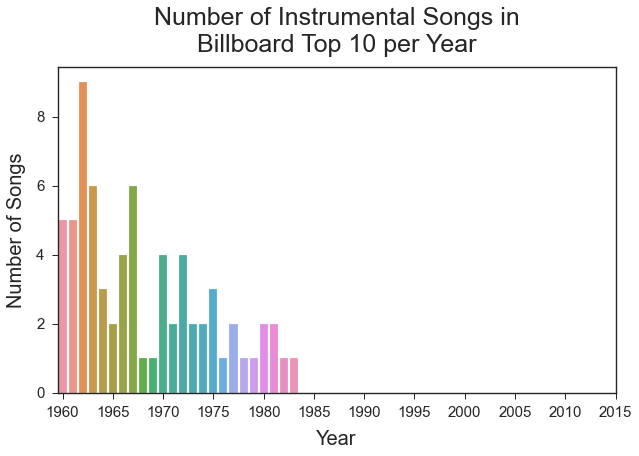

In [13]:
# graph number of instrumental songs per year
plt.figure(figsize=(10,6))
sns.barplot(x=instrumentals.year.value_counts().sort_index().index, y=instrumentals.year.value_counts().sort_index())
plt.title('Number of Instrumental Songs in\nBillboard Top 10 per Year', fontsize=25, pad=15)
plt.xlabel('Year', fontsize=20, labelpad=10)
plt.ylabel('Number of Songs', fontsize=20, labelpad=10)
plt.xticks(ticks=range(0,60,5), labels=range(1960,2021,5), fontsize=15)
plt.yticks(fontsize=15)
plt.show()

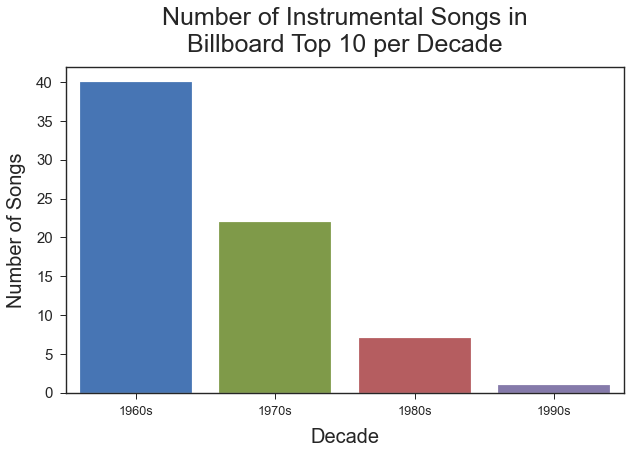

In [14]:
# graph number of instrumental songs per year
plt.figure(figsize=(10,6))
sns.barplot(x=instrumentals.decade.value_counts().sort_index().index, y=instrumentals.decade.value_counts().sort_index())
plt.title('Number of Instrumental Songs in\nBillboard Top 10 per Decade', fontsize=25, pad=15)
plt.xlabel('Decade', fontsize=20, labelpad=10)
plt.ylabel('Number of Songs', fontsize=20, labelpad=10)
# plt.xticks(ticks=range(0,60,5), labels=range(1960,2021,5), fontsize=15)
plt.yticks(fontsize=15)
plt.show()

- The 1960s had a lot of instrumentals make it into the Top 10. This noticeably fell in the 1970s, then continued to decline into the 1980s, the decade in which instrumentals made their last appearance.
- Now, I'll go ahead and drop these rows.

In [15]:
# drop instrumentals and reset index
df_update = df.dropna().reset_index(drop=True)

## Remove words in a line containing a colon

- I'll do a fairly targeted line transformer, designed to remove any lingering song structure (e.g. "Verse") delineations, as well as "Spoken:", and finally any speaker/singer (e.g. Lil Wayne:) delineations.
- NOTE: There may be some collateral damage here, but by keeping `total_kill=False`, the adverse effects should be exceptionally minimal. Even if it is set to true, it would only remove up to 2 words (including digits) before the colon.

In [16]:
df_update['lyrics'] = df_update.lyrics.map(lambda x: colon_killer(x, split_on=':', total_kill=False))

## Create list of lines



In [17]:
# create column with list of lines, removing any empty strings
df_update['lyrics_lined'] = df_update.lyrics.map(lambda x: [line for line in x.split('\n') if line])

# take a look
df_update.head()

,year,decade,title,artist,lyrics,lyrics_lined
0,1960,1960s,THE VILLAGE OF ST. BERNADETTE,Andy Williams,"I've traveled far, the land and the sea\nBeautiful places I happened to be\nOne little town I'll never forget\nIs Lourdes, the village of St. Bern...","[I've traveled far, the land and the sea, Beautiful places I happened to be, One little town I'll never forget, Is Lourdes, the village of St. Ber..."
1,1960,1960s,IN MY LITTLE CORNER OF THE WORLD,Anita Bryant,"Oh, come along with me\nTo my little corner of the world\nAnd dream a little dream\nIn my little corner of the world\n\nTonight, my love\nWe'll sh...","[Oh, come along with me, To my little corner of the world, And dream a little dream, In my little corner of the world, Tonight, my love, We'll sha..."
2,1960,1960s,PAPER ROSES,Anita Bryant,I realize the way your eyes deceived me\nWith tender looks that I mistook for love\nSo take away the flowers that you gave me\nAnd send the kind t...,"[I realize the way your eyes deceived me, With tender looks that I mistook for love, So take away the flowers that you gave me, And send the kind ..."
3,1960,1960s,O DIO MIO,Annette,"E un giorno lui mi disse: ""Nei tuoi occhi vedo fame\nNon vedo rabbia, figlio, no\nMa voglia di lottare.""\nDivisi il cibo nel mio piatto col rivale...","[E un giorno lui mi disse: ""Nei tuoi occhi vedo fame, Non vedo rabbia, figlio, no, Ma voglia di lottare."", Divisi il cibo nel mio piatto col rival..."
4,1960,1960s,WONDERLAND BY NIGHT,Bert Kaempfert,Stars hang suspended\nAbove a floating yellow moon\nTwo hearts were blended\nWhile angels sang a lover's tune\n\nAnd so we kissed\nNot knowing if ...,"[Stars hang suspended, Above a floating yellow moon, Two hearts were blended, While angels sang a lover's tune, And so we kissed, Not knowing if o..."


### Save/Load

In [18]:
# uncomment to save
with gzip.open('data/lyrics_df_clean.pkl', 'wb') as goodbye:
    pickle.dump(df_update, goodbye, protocol=pickle.HIGHEST_PROTOCOL)
    
# # uncomment to load
# with gzip.open('data/lyrics_df_clean.pkl', 'rb') as hello:
#     df_update = pickle.load(hello)

# Something to consider for EDA notebook

In [19]:
features = df[df.artist.str.contains('eaturing')]
features.head()

,year,decade,title,artist,lyrics
91,1960,1960s,THE OLD LAMPLIGHTER,The Browns Featuring Jim Edward Brown,"He made the night a little brighter\nWherever he would go\nThe old lamplighter\nOf long, long ago\n\nHis snowy hair was so much whiter\nBeneath th..."
312,1962,1960s,THE LONELY BULL (El Solo Torro),The Tijuana Brass Featuring Herb Alpert,NaN
685,1966,1960s,GOOD THING,Paul Revere and the Raiders Featuring Mark Lindsay,"Shh, ahh\nSeems this world has got you down\nYou're feeling bad vibrations frown\nWell, open your eyes, girl, look at me (look at me)\nI'm gonna s..."
686,1966,1960s,HUNGRY,Paul Revere and the Raiders Featuring Mark Lindsay,Girl you got this need to know what I'm all about\nThere is something that you dig you can't figure out\nWell now you want to know what moves my s...
687,1966,1960s,KICKS,Paul Revere and the Raiders featuring Mark Lindsay,"Girl, you thought you found the answer on that magic carpet ride last night\nBut when you wake up in the mornin' the world still gets you uptight\..."


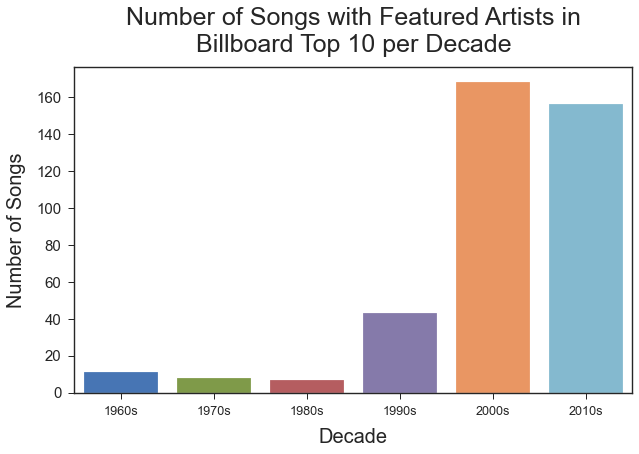

In [20]:
# graph number of instrumental songs per year
plt.figure(figsize=(10,6))
sns.barplot(x=features.decade.value_counts().sort_index().index, y=features.decade.value_counts().sort_index())
plt.title('Number of Songs with Featured Artists in\nBillboard Top 10 per Decade', fontsize=25, pad=15)
plt.xlabel('Decade', fontsize=20, labelpad=10)
plt.ylabel('Number of Songs', fontsize=20, labelpad=10)
# plt.xticks(ticks=range(0,60,5), labels=range(1960,2021,5), fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [21]:
please break code

SyntaxError: invalid syntax (<ipython-input-21-b8306b2d38fe>, line 1)

# GRAVEYARD

In [ ]:
df_update[df_update.lyrics.str.contains(':')]

In [ ]:
print(df_update.loc[4621, 'lyrics'])

In [ ]:
df_update.loc[3, 'lyrics'].split('\n')[0]

In [ ]:
df_update.loc[3, 'lyrics'].split('\n')[0].split(':')[0].split()

In [ ]:
print(colon_killer(df_update.loc[3, 'lyrics']))

In [ ]:

df_update.loc[148, 'lyrics_lined']

- Remove lines ending with colon?
- Remove lines with "spoken:"? Maybe just remove "spoken:", strip, and take it from there. Could also just include "spoken" in stop words.
- Remove parentheses?
    - Problem with this is that they are often used to contain backup vocals, meaning I would lose some lyrics.
- Remove colon and the word(s) preceding it? (generally someones name or spoken)